#######################################################################################################################
# SQLAlchemy Homework
### Following code solves the homework for the SQLAlchemy Assignment. 
### A second section related to using Flask for generating API calls is contained in the python code app.py

#######################################################################################################################

In [1]:
#Importing required modules
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt

In [4]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect, distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
#checking names of tables contained in sql database
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurement', 'station']

In [8]:
#creating object for measurement and station
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

In [9]:
#setting up inspector and confirming table names
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [10]:
# Get a list of column names and types in measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types in station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

### The following analysis extracts the precipitation from the last 12 months of the SQL database and plots the daily precipitation and then prints the total monthly precipitation calculated from the data.  The second plot was not requested in the readme file but the starter code seemed to ask for the monthly average so did both.


In [12]:
#Analysis of precipitation data to find the maximum and minimum date in the sheet.
sel = [ Measurement.date, Measurement.prcp] #pulling only date and precipitation.
weather_data = session.query(*sel).all() 
session.close()

min_date_record = dt.date(3000,1,1)
max_date = dt.date(1900,1,1) #need this as dummy for starting to analyze the data.  If this was returned as max date
                                #would have to set as lower number.
for record in weather_data:
    (ME_date, ME_Prec) = record
    if ME_date > str(max_date):
        max_date = ME_date
    if ME_date < str(min_date_record):
        min_date_record = ME_date
print(f"The latest date in the data base is: {max_date}")
print(f"The earliest date in the data base is: {min_date_record}")

The latest date in the data base is: 2017-08-23
The earliest date in the data base is: 2010-01-01


In [13]:
#finding last twelve months in database
YMD = max_date.split('-')
max_date = dt.date(int(YMD[0]),int(YMD[1]),int(YMD[2]))
min_date = max_date - dt.timedelta(days=365)
print(f"End date of database (most recent year): {max_date}")
print(f"Start date for 12 months earlier: {min_date}")

End date of database (most recent year): 2017-08-23
Start date for 12 months earlier: 2016-08-23


In [14]:
#opening query to extract information from both tables 
#sel list is date and precipitation
sel = [ Measurement.date, Measurement.prcp] #pulling only date and precipitation.
weather_filter = session.query(*sel).\
    filter((Measurement.date <= max_date)& (Measurement.date >= min_date)).all()
session.close()


#creating dataframe with information as dictated in directions.
precip_df = pd.DataFrame(columns = ["Date","Precip"])
for record in weather_filter:
    (ME_date, ME_Prec) = record
    precip_df = precip_df.append({"Date":ME_date, "Precip":ME_Prec}, ignore_index = True)
precip_df.dropna(inplace = True)
precip_df = precip_df.set_index("Date")
precip_df.sort_index(inplace=True)
precip_df.head(10)

,Precip
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


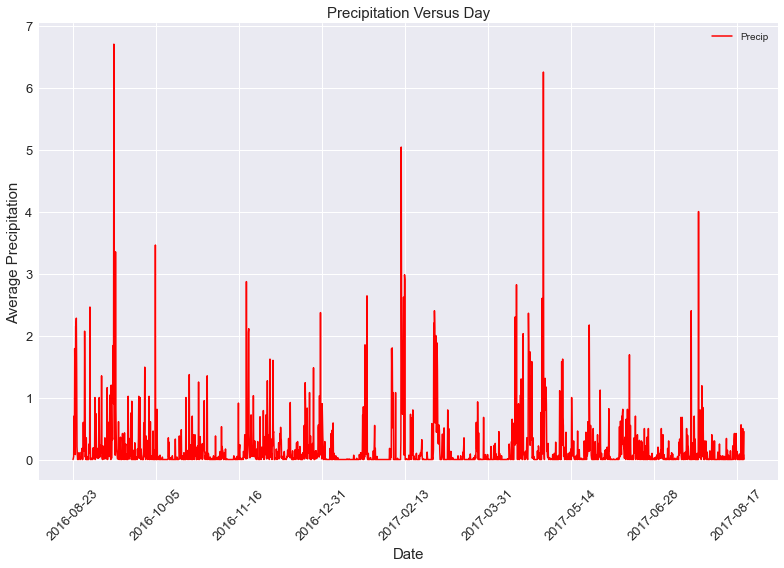

In [17]:
#creating plot of daily average precipitation.  Using Datafram plot method.
precip_df.plot(kind="line", color = "r", figsize=(11,8),lw=1.5,fontsize=13)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Average Precipitation",fontsize=15)
plt.title( "Precipitation Versus Day",fontsize = 15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
print("Summary Statistics for Precipitation Date\n")

print(precip_df["Precip"].describe())

Summary Statistics for Precipitation Date

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precip, dtype: float64


### Following is extra work looking at precipitation over date range by month

In [19]:
#dataframe includes data from many stations. Therefore perform groupby on date and then average for day of all stations.

precip_groupby = precip_df.groupby("Date")
precip_group_series = precip_groupby["Precip"].mean()
precip_group_df = pd.DataFrame({'Date':precip_group_series.index, 'Precip':precip_group_series.values})
precip_group_df = precip_group_df.set_index('Date')
precip_group_df.sort_index(inplace=True)



In [20]:
#Extracting Month and year from date and placing in dataframe.  To help in finding monthly sum.
date_series = precip_group_df.index.to_series()
precip_group_df["Month"]=[int((precip_group_df.index[i]).split('-')[1]) for i in range(0,len(date_series))]
precip_group_df["Year"]=[int((precip_group_df.index[i]).split('-')[0]) for i in range(0,len(date_series))]


In [21]:
#using group by to find total precip for month.  August is incomplete so combine Aug from 2016 and 2017
precip_groupby = precip_group_df.groupby(["Year","Month"])
precip_monthly_average = precip_groupby["Precip"].sum()
precip_monthly_average[0]=precip_monthly_average[0]+precip_monthly_average[-1]
precip_monthly_average = precip_monthly_average.head(12)

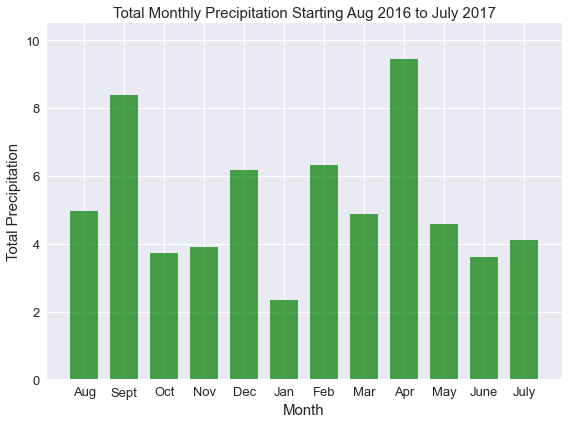

In [22]:
#Setting up bar chart for monthly total precipation over specified date range
#gettign data for plot
x_data = [precip_monthly_average.index[i][1] for i in range(0,len(precip_monthly_average))] #extracting month into series
y_data = [round(precip_monthly_average[i],2) for i in range(0,len(precip_monthly_average))] #extracting precip into series

#creating month association dictionnary to use name of month rather than number in plot.
Month_Assoc = [(1, 'Jan'), (2, 'Feb'), (3,'Mar'), (4, 'Apr'), (5,'May'),(6,'June'),
              (7, 'July'),(8,'Aug'),(9,'Sept'),(10,'Oct'),(11,'Nov'),(12,'Dec')]

x_data_month = []
#Creating list of months by name in order of x_data
for i in range(0,len(x_data)):
    for j in range(0,len(Month_Assoc)):
        if x_data[i] == Month_Assoc[j][0]:
            x_data_month.append(Month_Assoc[j][1])
            break

plt.figure(figsize=(8,6))
plt.bar(x_data_month, y_data, color='g', width = 0.7, alpha=0.7, align="center") #alpha is how transparent bars are
plt.ylim(0, 10.5)

plt.title("Total Monthly Precipitation Starting Aug 2016 to July 2017",fontsize=15)
plt.xlabel("Month",fontsize=15)
plt.ylabel("Total Precipitation",fontsize=15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.tight_layout() #tight layout helps to arrange the graph to look nicer

plt.show()

## Code below gets information for stations

In [23]:
# Get a list of column names and types in station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
session.close()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
# Design a query to show how many stations are available in this dataset?

station_count, = (session.query(func.count(Station.id)).all())
session.close()

print(f"Number of Stations: {station_count}")


Number of Stations: (9,)


In [25]:

Stations = session.query(Station.station, Station.name).all() 
session.close()

#Get station name list to help search through for maximum counts
station_list = []
station_name = []
for record in Stations:
    station = record[0]
    name = record[1]
    station_list.append(station)
    station_name.append(name)
print("")

#Use data from above to get station counts, store in station_counts_df as DataFrame
station_counts_df = pd.DataFrame(columns = ["Station","Counts"])
for stn in station_list:
    temp = session.query(Measurement.station,func.count(Measurement.station)).\
                filter(Measurement.station == stn).\
                order_by(func.count(Measurement.station)).all()
    station_counts_df = station_counts_df.append({"Station":temp[0][0],"Counts":temp[0][1]}, ignore_index = True)
session.close()
station_counts_df.sort_values(["Counts"],ascending = False,inplace=True)

print(f"List of stations and station name")
print("")
print(station_list)
print(station_name)


List of stations and station name

['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128']
['WAIKIKI 717.2, HI US', 'KANEOHE 838.1, HI US', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'PEARL CITY, HI US', 'UPPER WAHIAWA 874.3, HI US', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'WAIHEE 837.5, HI US', 'HONOLULU OBSERVATORY 702.2, HI US', 'MANOA LYON ARBO 785.2, HI US']


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#Easy to sort in DataFrame
print(station_counts_df)
station_max = station_counts_df.iloc[0][0]

print(f"The station with the highest counts is: {station_counts_df.iloc[0][0]}")

       Station Counts
6  USC00519281   2772
0  USC00519397   2724
1  USC00513117   2709
5  USC00519523   2669
8  USC00516128   2612
2  USC00514830   2202
7  USC00511918   1979
3  USC00517948   1372
4  USC00518838    511
The station with the highest counts is: USC00519281


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)]
temp_detail, = session.query(*sel).\
                filter(Measurement.station == station_max).all()

print(f"The highest temperature from {station_max} is {temp_detail[0]} F")
print(f"The lowest temperature from {station_max} is {temp_detail[1]} F")
print(f"The average temperature from {station_max} is {round(temp_detail[2],1)} F")

The highest temperature from USC00519281 is 85.0 F
The lowest temperature from USC00519281 is 54.0 F
The average temperature from USC00519281 is 71.7 F


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station,Measurement.date, Measurement.tobs]
temp_survey = session.query(*sel).\
                filter(Measurement.station == station_max).\
                filter((Measurement.date <= max_date)& (Measurement.date >= min_date)).all()

temp_survey_df = pd.DataFrame(columns = ["Station","Date", "Temp"])
for record in temp_survey:
    (Me_date, Me_stn,Me_temp) = record
    temp_survey_df = temp_survey_df.append({"Station":Me_date,"Date":Me_stn,"Temp":Me_temp}, ignore_index = True)
    
temp_survey_df.head()

,Station,Date,Temp
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0


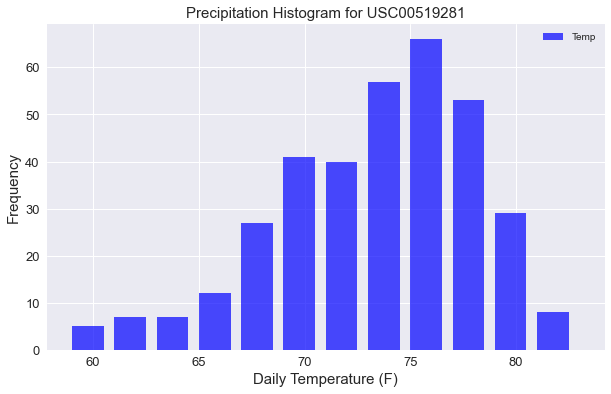

In [29]:
temp_survey_df.plot.hist(by="Temp", bins=12,color = "b", width = 1.5,alpha = 0.7,
                         figsize=(10,6))
plt.xlabel("Daily Temperature (F)",fontsize = 15)
plt.ylabel("Frequency",fontsize=15)
plt.title(f"Precipitation Histogram for {station_max}",fontsize=15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

########################################################################################################

# Section 2 - Use of Flask

### Please see the app.py routine for this section of code

########################################################################################################

## Bonus Challenge Assignment
### Read me file shows two challenges Temperature Analysis I and Analysis II

#### Bonus Temperature Analysis I

In [30]:
from statistics import mean
import scipy.stats as stats

In [31]:
#Bonus Temperature Analysis #1 - Taken from Readme file
#Get all temperatures in June and December from Database and perform statistical test of significance

# Query for all dates matching the 
# following date string in the format `%d`
date_str = "06" #June is 6th month
sel = [Measurement.date,Measurement.tobs]
June_Temp = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
session.close()

J_Temp = []
for record in June_Temp:
    (Me_date,Me_temp) = record
    J_Temp.append(Me_temp)

#Getting December Date
date_str = "12" #June is 6th month
sel = [Measurement.date,Measurement.tobs]
Dec_Temp = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
session.close()

D_Temp = []
for record in Dec_Temp:
    (Me_date,Me_temp) = record
    D_Temp.append(Me_temp)


#For t-test using two sample t-test since the Temperatures in June and Dec are taken from different populations
T_Test = stats.ttest_ind(a=J_Temp,b=D_Temp,equal_var=False)
p_value = T_Test[1]
print(f"t-Test comparing June and Dec Temperatures in Hawaii")
print("")
print(T_Test)
print("")
if p_value > 0.05:
    print(f"The p_value of {p_value} is greater than 0.05 so can't reject Null Hypothesis")
else:
    print(f"The p_value of {p_value} is less than or equal to 0.05 so reject the Null Hypothesis")


t-Test comparing June and Dec Temperatures in Hawaii

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

The p_value of 4.193529835915755e-187 is less than or equal to 0.05 so reject the Null Hypothesis


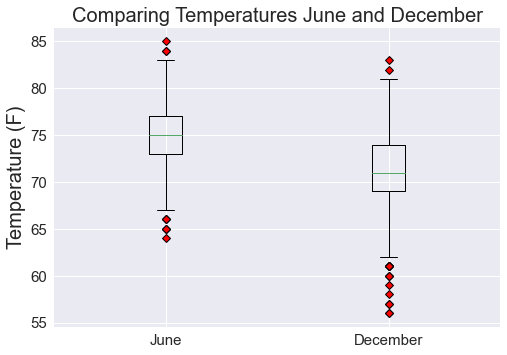

In [32]:
#Generating a box plot to help visualize
red_diamond = dict(markerfacecolor='r', marker='D')
labels = ['June', 'December']

fig1, ax1 = plt.subplots()
ax1.set_title('Comparing Temperatures June and December', fontsize = 20)
ax1.set_ylabel('Temperature (F)', fontsize = 20)
ax1.boxplot([J_Temp,D_Temp], showfliers = True,
           flierprops = red_diamond, labels=labels)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.show()

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]



Average Temperature from 2016-08-23 to 2017-08-23: 74.59 F



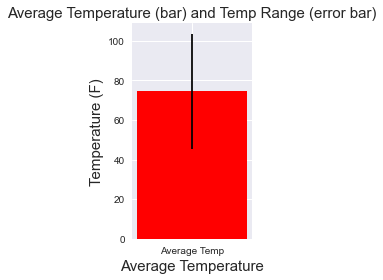

In [57]:
stop = str(max_date)
Temp_Data = calc_temps('2016-08-23', '2017-08-23')

T_Avg = Temp_Data[0][1]
T_min = Temp_Data[0][0]
T_max = Temp_Data[0][2]
T_Delta = T_max-T_min

x_axis = "Average Temp" 
y_axis = T_Avg


print("")
print(f"Average Temperature from 2016-08-23 to 2017-08-23: {round(T_Avg,2)} F")
print("")

plt.figure(figsize=(4,4)) #10 inches wide by 4" tall

plt.bar(x_axis, y_axis, color='r', width = 0.5, alpha=1, align="center", yerr=T_Delta,capsize=10) #alpha is how transparent bars are


plt.title("Average Temperature (bar) and Temp Range (error bar)", fontsize=15)
plt.xlabel("Average Temperature", fontsize=15)
plt.ylabel("Temperature (F)", fontsize=15)

plt.tight_layout() #tight layout helps to arrange the graph to look nicer

plt.show()


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
